In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import time
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mapie.multi_label_classification import MapieMultiLabelClassifier
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/polyp"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/polyp/03_model_weights/resnet"
MODEL_NAME = "20240325_1446"

In [5]:
# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [6]:
IMG_SIZE = 64
RESNET_EMBEDDING_SIZE = config["model"]["embedding_size"]


In [7]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_CAL_IMAGES = os.path.join(BASE_DIR, "02_prepared_data/cal/images")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")
DIR_TEST_IMAGES = DIR_CAL_IMAGES.replace("cal", "test")

DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")


In [8]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), RESNET_EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(
        tqdm(zip(
            sorted(os.listdir(pred_probas_dir)),
            sorted(os.listdir(res_emb_dir)),
            sorted(os.listdir(labels_dir))
        ))
    ):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [9]:
cal_pred_probas, cal_res_emb, cal_labels = load_data(
    DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS
)


252it [00:03, 72.06it/s] 


In [10]:
test_pred_probas, test_res_emb, test_labels = load_data(
    DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS
)

546it [00:00, 931.28it/s] 


In [11]:
index_not_empy = np.where(cal_labels.sum(axis=(1, 2)) > 0)[0]
cal_labels = cal_labels[index_not_empy]
cal_res_emb = cal_res_emb[index_not_empy]
cal_pred_probas = cal_pred_probas[index_not_empy]


In [12]:
cal_res_emb = np.concatenate([np.ones((cal_res_emb.shape[0], 1)), cal_res_emb], axis=1)
test_res_emb = np.concatenate([np.ones((test_res_emb.shape[0], 1)), test_res_emb], axis=1)

RESNET_EMBEDDING_SIZE += 1

In [13]:
ALPHA = .1
N = len(cal_labels)
REGULARIZATION = "ridge"

# Fit CRC

In [14]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = 1

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return pred_proba >= .5

    def __sklearn_is_fitted__(self):
        return True

In [15]:
mapie_crc = MapieMultiLabelClassifier(MapieWrapper(), method="crc")
mapie_crc.lambdas = np.arange(0, 1, 0.001)
for i in tqdm(range(len(cal_pred_probas))):
    X, y = cal_pred_probas[i], cal_labels[i]
    mapie_crc.partial_fit(X.ravel()[np.newaxis, :], y.ravel()[np.newaxis, :])

100%|██████████| 252/252 [00:05<00:00, 48.74it/s]


In [16]:
_, _ = mapie_crc.predict(test_pred_probas.ravel()[np.newaxis, :], alpha=ALPHA)
th_crc = mapie_crc.lambdas_star
th_crc

array([0.276])

In [17]:
mapie_crc.risks.shape

(252, 1000)

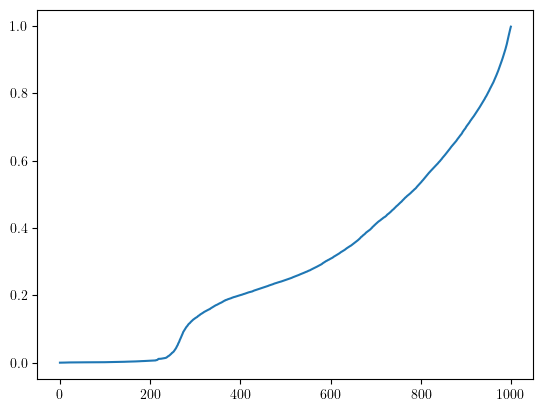

In [18]:
plt.plot(mapie_crc.risks.mean(axis=0))

# Fit multi-accurate with ResNet embedding

In [19]:
lambda_resnet = .01
result_res = minimize(
    J, np.random.uniform(0, 1, RESNET_EMBEDDING_SIZE),
    method="SLSQP",
    args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, N, REGULARIZATION, lambda_resnet), jac=J_prime,
    options={"disp": True, "maxiter": 1000}, tol=1e-10
)
ths_res = (test_res_emb @ result_res.x).reshape(-1, 1, 1)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.629058070741166
            Iterations: 23
            Function evaluations: 43
            Gradient evaluations: 23


# Apply thresholds on pred-probas

In [20]:
y_pred_test_th_resnet = (test_pred_probas >= ths_res).astype(int)
recall_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

y_pred_test_th_crc = (test_pred_probas >= th_crc).astype(int)
recall_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

In [21]:
precision_test_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2))
precision_test_crc =(y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2))


/tmp/ipykernel_4004712/3101535864.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2))


# Plot results

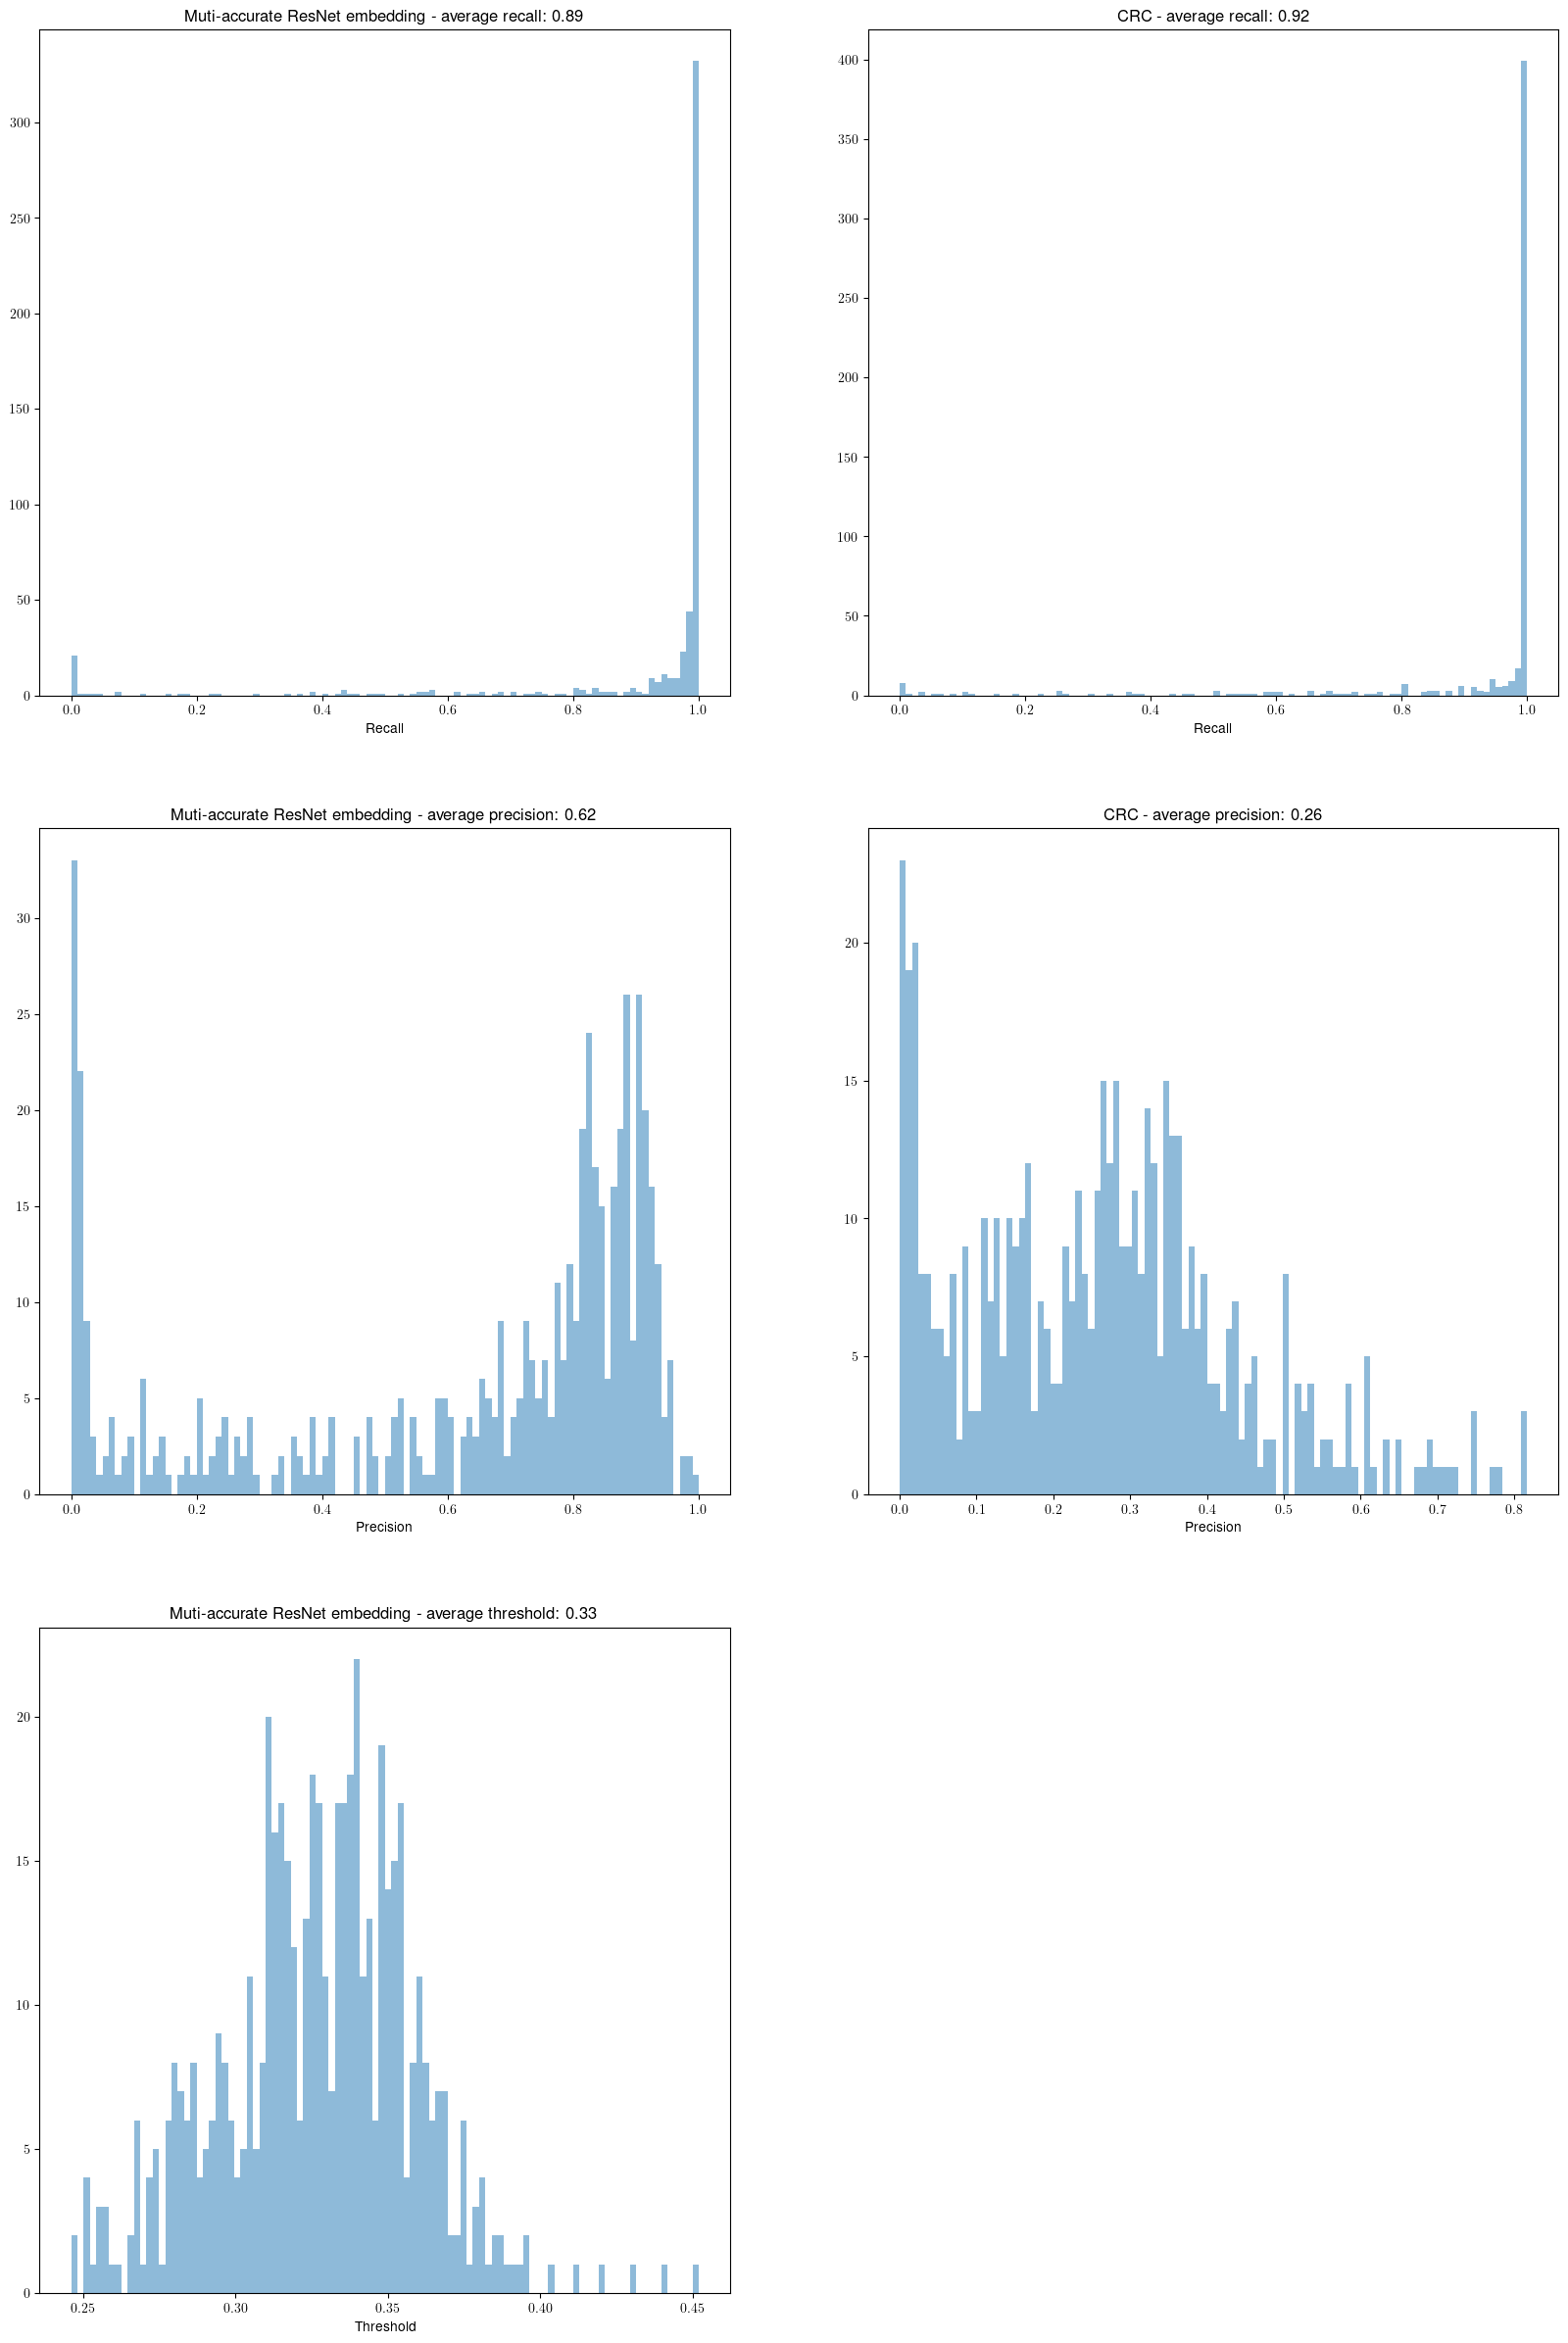

In [22]:
s = 10
nrow = 3
ncol = 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s))

ax[0, 0].hist(recall_resnet, bins=100, alpha=.5)
ax[0, 0].set_title(f"Muti-accurate ResNet embedding - average recall: {np.nanmean(recall_resnet):.2f}")
ax[0, 0].set_xlabel("Recall")

ax[0, 1].hist(recall_test_crc, bins=100, alpha=.5)
ax[0, 1].set_title(f"CRC - average recall: {np.nanmean(recall_test_crc):.2f}")
ax[0, 1].set_xlabel("Recall")

ax[1, 0].hist(precision_test_resnet, bins=100, alpha=.5)
ax[1, 0].set_title(f"Muti-accurate ResNet embedding - average precision: {np.nanmean(precision_test_resnet):.2f}")
ax[1, 0].set_xlabel("Precision")

ax[1, 1].hist(precision_test_crc, bins=100, alpha=.5)
ax[1, 1].set_title(f"CRC - average precision: {np.nanmean(precision_test_crc):.2f}")
ax[1, 1].set_xlabel("Precision")


ax[2, 0].hist(ths_res[:, 0, 0], bins=100, alpha=.5)
ax[2, 0].set_title(f"Muti-accurate ResNet embedding - average threshold: {np.nanmean(ths_res):.2f}")
ax[2, 0].set_xlabel("Threshold")

ax[2, 1].set_axis_off()

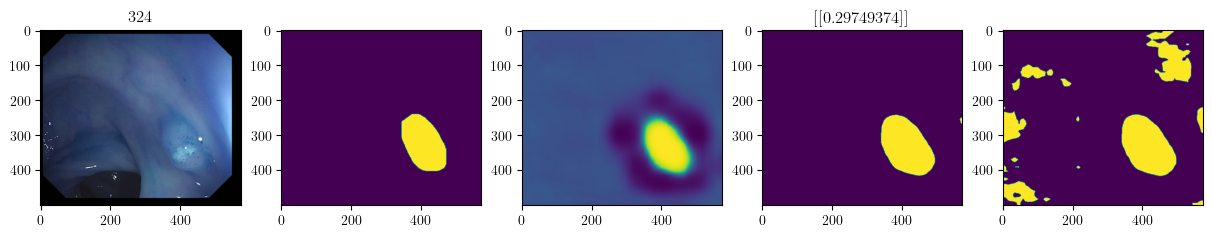

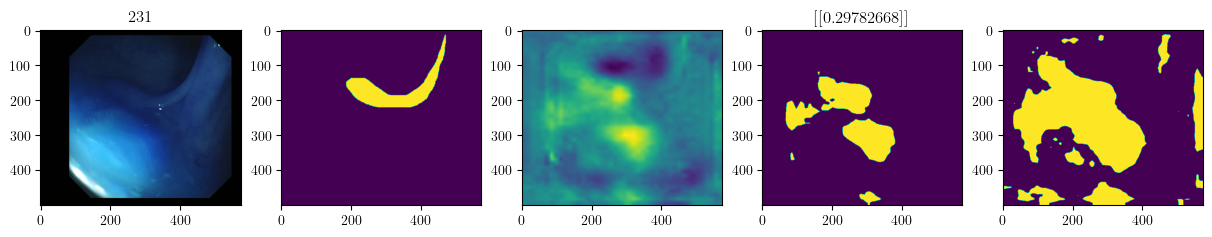

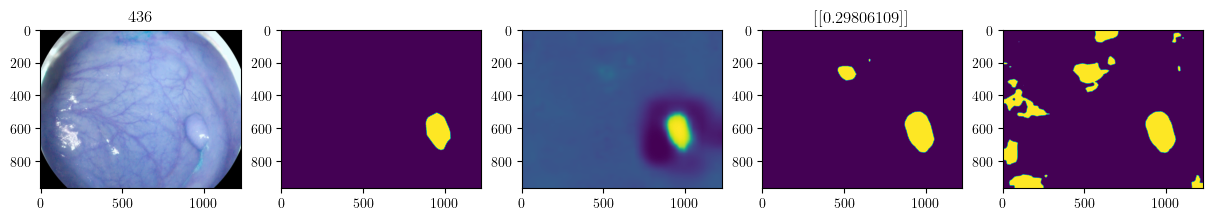

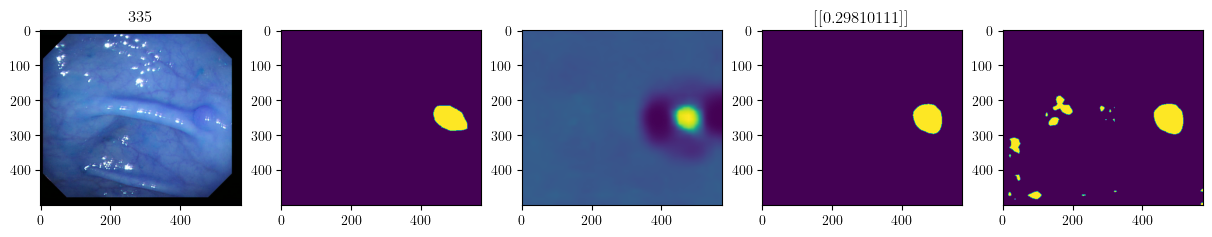

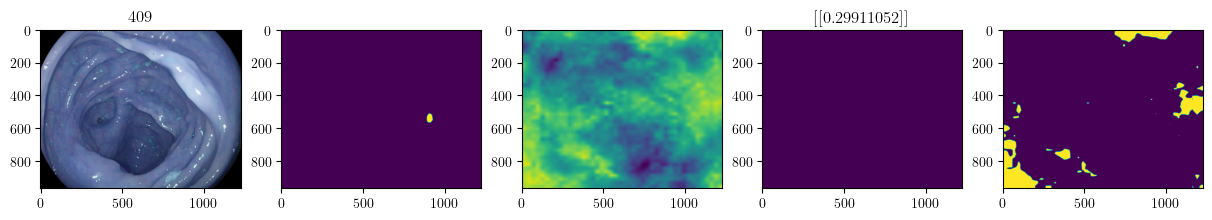

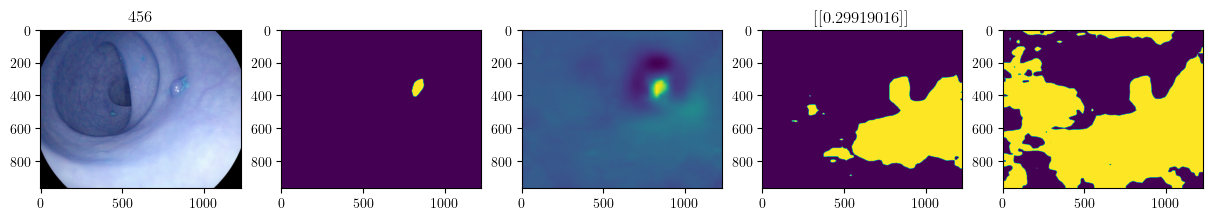

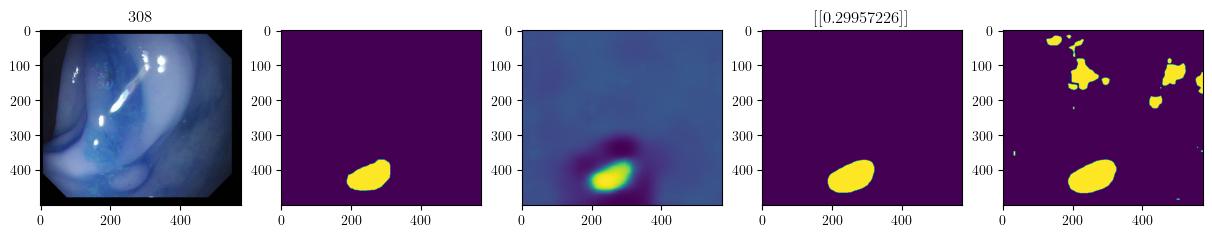

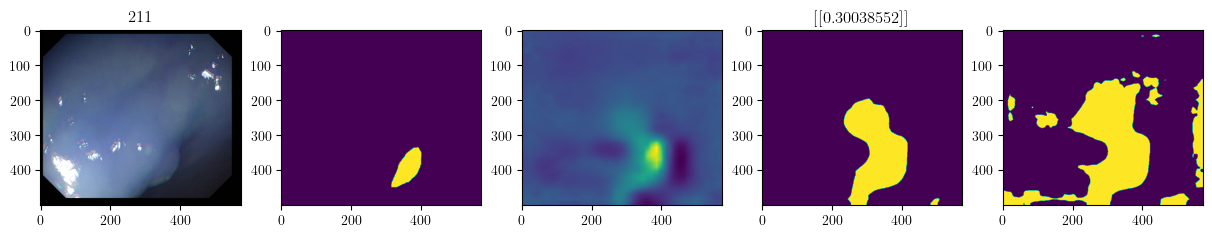

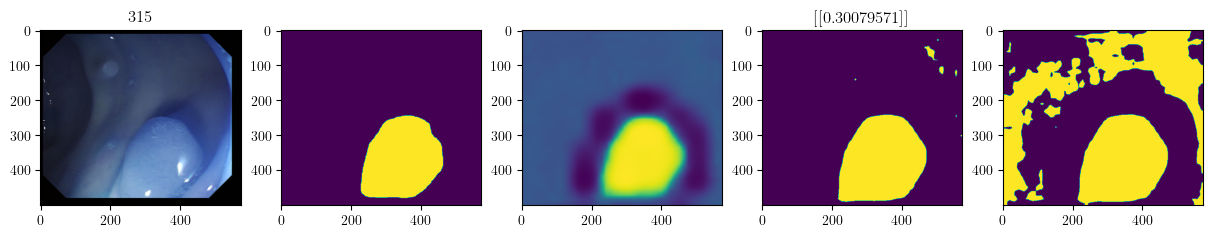

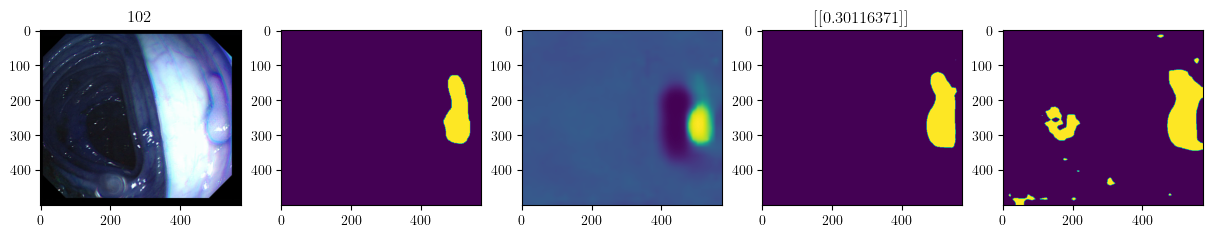

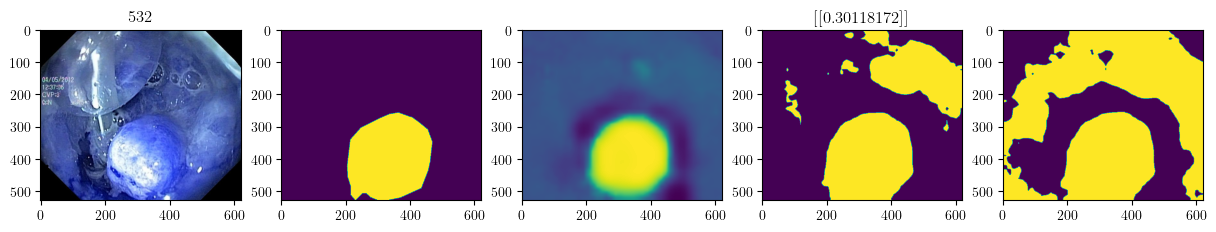

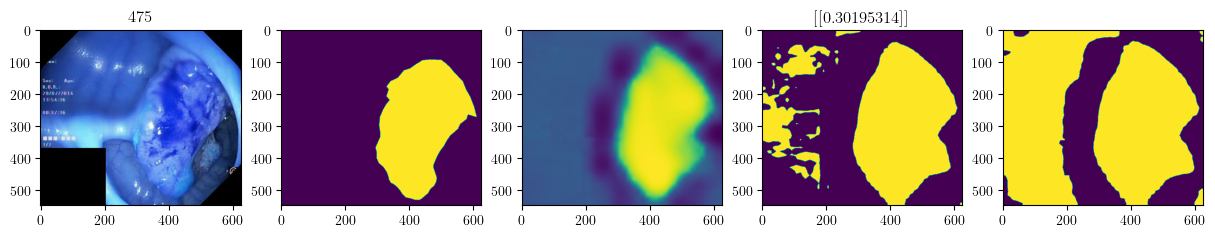

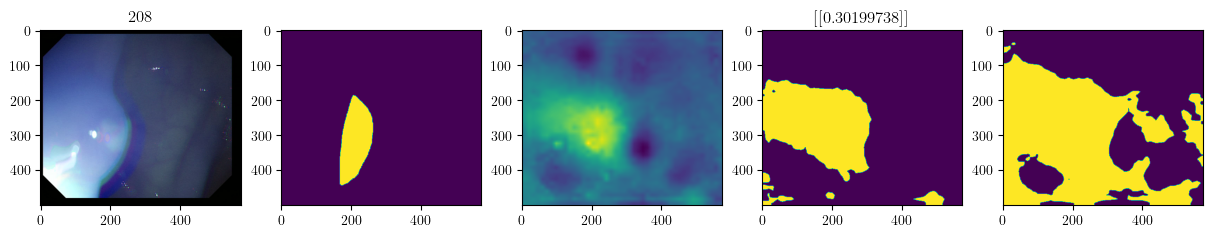

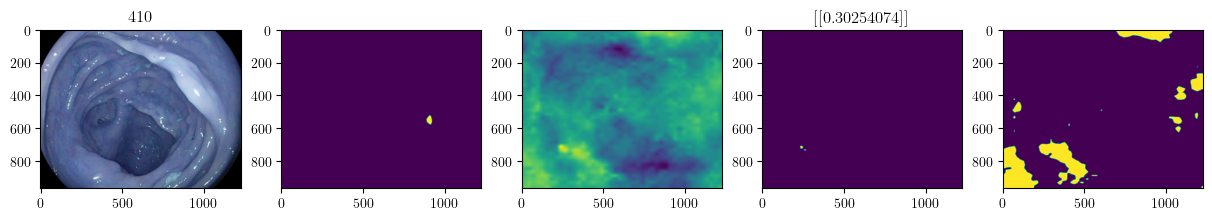

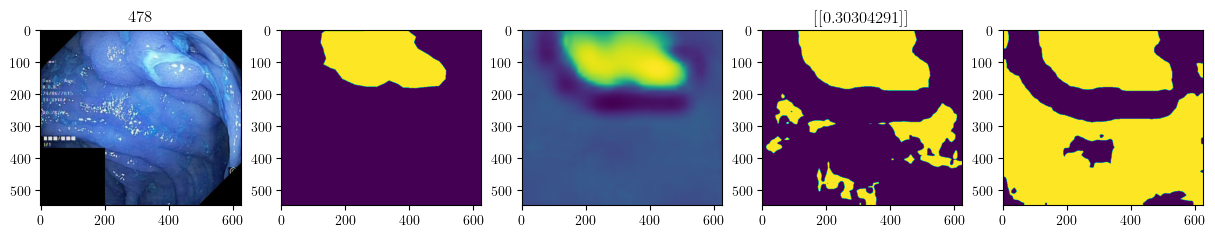

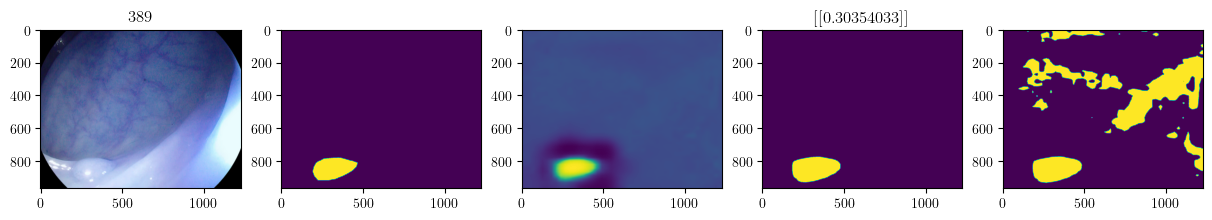

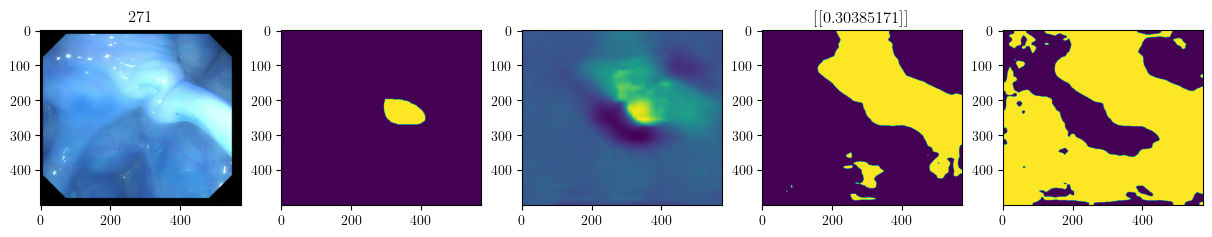

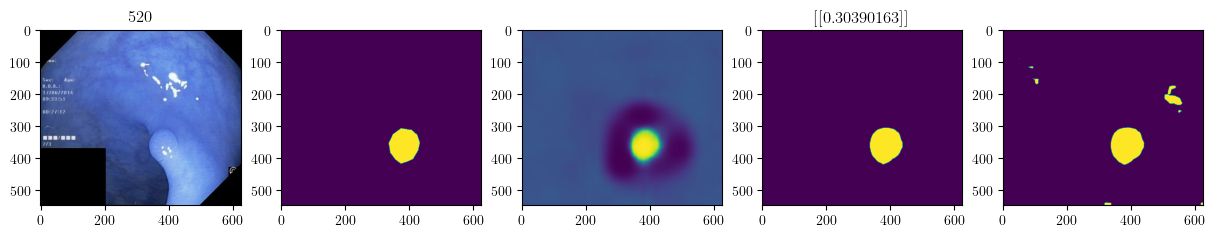

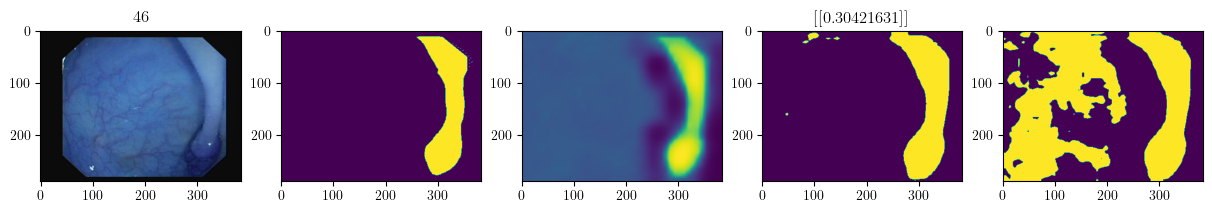

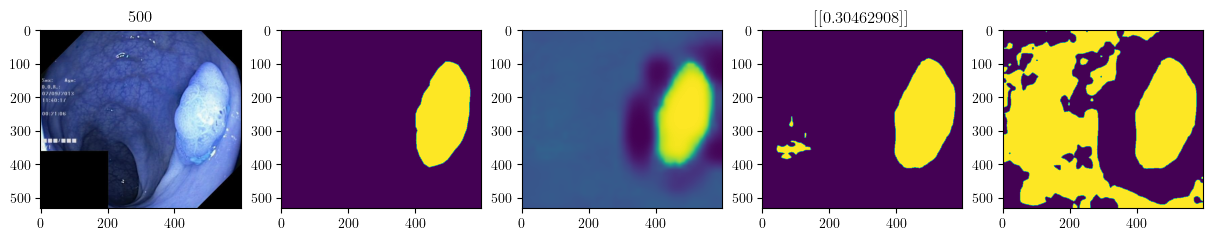

In [31]:
s = 3
for i in range(20):
    arg = np.argsort(ths_res[:, 0, 0])[100+i]
    f, ax = plt.subplots(1, 5, figsize=(5 * s, s))
    img_arg = cv2.imread(os.path.join(DIR_TEST_IMAGES, sorted(os.listdir(DIR_TEST_IMAGES))[arg]))
    ax[0].imshow(img_arg)
    labels_arg = cv2.imread(os.path.join(DIR_TEST_LABELS, sorted(os.listdir(DIR_TEST_LABELS))[arg]), cv2.IMREAD_GRAYSCALE)
    pred_proba_arg = np.load(os.path.join(DIR_TEST_PRED_PROBAS, sorted(os.listdir(DIR_TEST_PRED_PROBAS))[arg]))
    ax[1].imshow(labels_arg)
    ax[2].imshow(pred_proba_arg)
    ax[3].imshow(pred_proba_arg >= ths_res[arg])
    ax[3].set_title(ths_res[arg])
    ax[4].imshow(pred_proba_arg >= th_crc)
    ax[0].set_title(arg)
    plt.show()




In [37]:
th_crc[0]

0.276

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


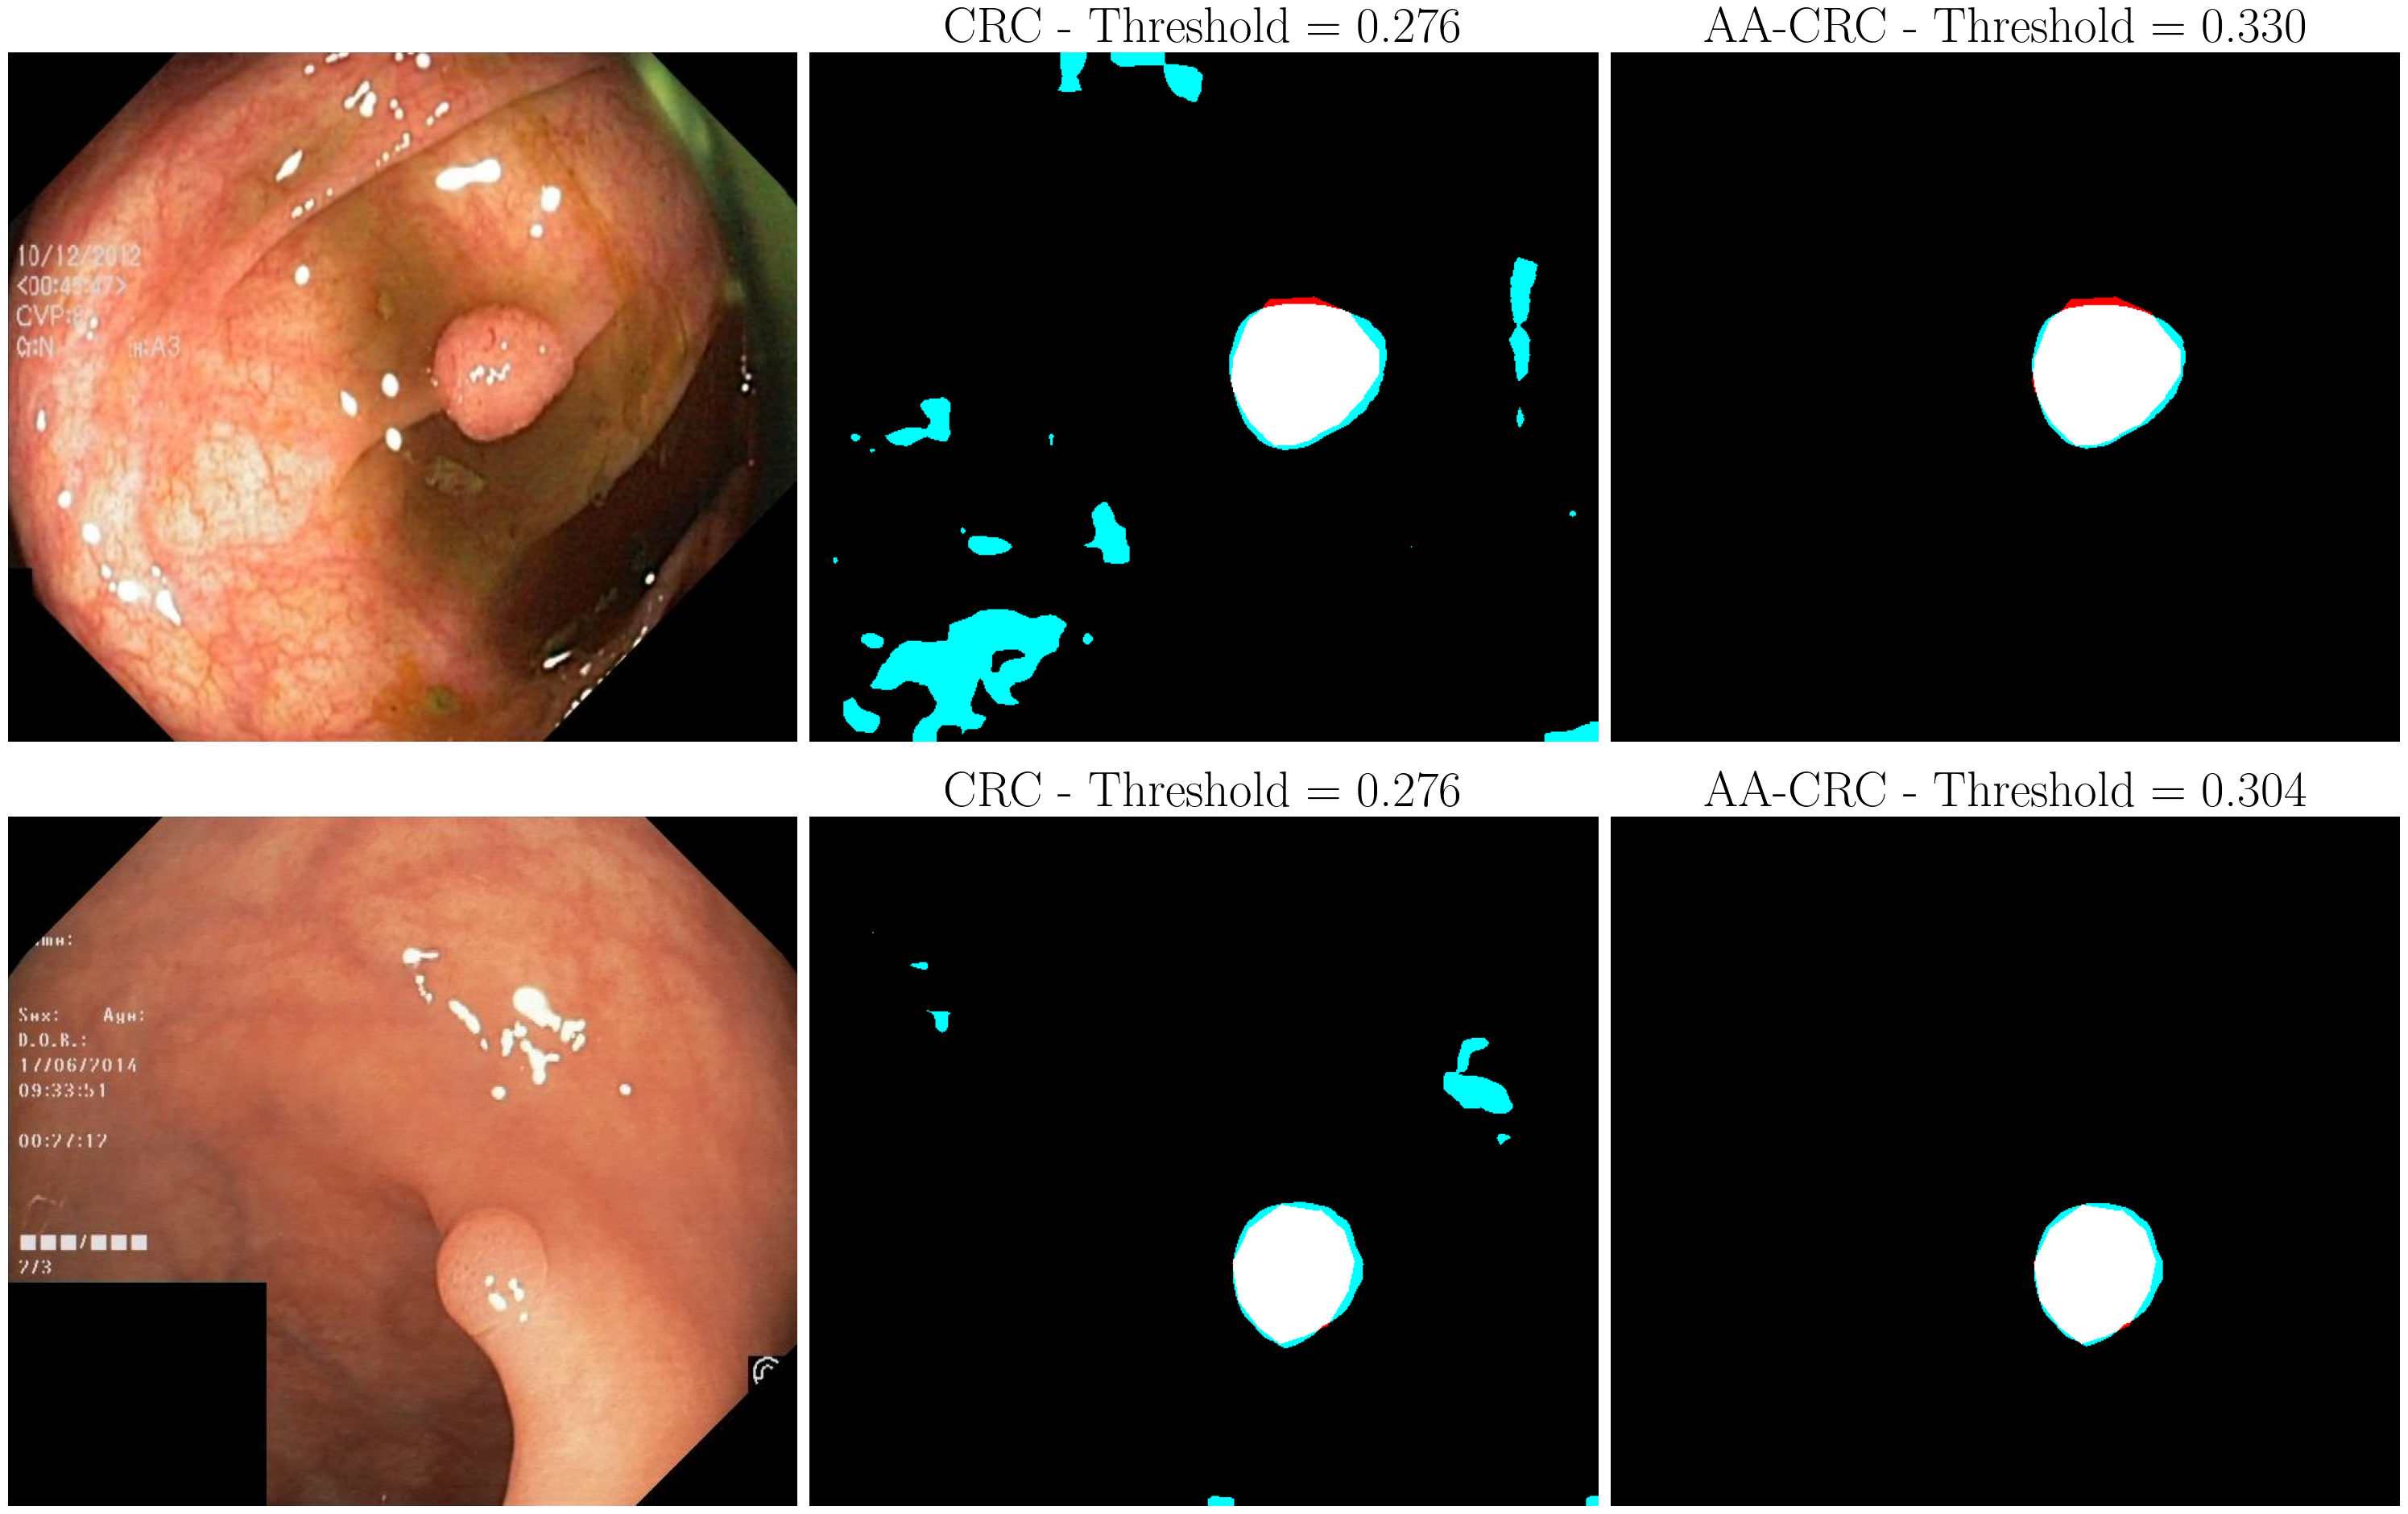

In [66]:
494
520
ncols = 3
nrows = 2
s = 10
FS = 45
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s))

ths_494 = ths_res[494]
ths_520 = ths_res[520]

label_494 = cv2.imread(os.path.join(DIR_TEST_LABELS, sorted(os.listdir(DIR_TEST_LABELS))[494]), cv2.IMREAD_GRAYSCALE)
label_520 = cv2.imread(os.path.join(DIR_TEST_LABELS, sorted(os.listdir(DIR_TEST_LABELS))[520]), cv2.IMREAD_GRAYSCALE)

pred_probas_494 = np.load(os.path.join(DIR_TEST_PRED_PROBAS, sorted(os.listdir(DIR_TEST_PRED_PROBAS))[494]))
pred_probas_520 = np.load(os.path.join(DIR_TEST_PRED_PROBAS, sorted(os.listdir(DIR_TEST_PRED_PROBAS))[520]))

pred_th_494_res = pred_probas_494 >= ths_494
pred_th_520_res = pred_probas_520 >= ths_520

pred_th_494_crc = pred_probas_494 >= th_crc
pred_th_520_crc = pred_probas_520 >= th_crc

img_494 = cv2.imread(os.path.join(DIR_TEST_IMAGES, sorted(os.listdir(DIR_TEST_IMAGES))[494]))
img_520 = cv2.imread(os.path.join(DIR_TEST_IMAGES, sorted(os.listdir(DIR_TEST_IMAGES))[520]))

img_494 = cv2.resize(img_494, (img_520.shape[1], img_520.shape[0]))
pred_proba_494 = cv2.resize(pred_probas_494, (img_520.shape[1], img_520.shape[0]))
pred_th_494_res = cv2.resize(pred_th_494_res.astype(np.uint8), (img_520.shape[1], img_520.shape[0]))
pred_th_494_crc = cv2.resize(pred_th_494_crc.astype(np.uint8), (img_520.shape[1], img_520.shape[0]))
label_494 = cv2.resize(label_494, (img_520.shape[1], img_520.shape[0]))

img_494 = cv2.cvtColor(img_494, cv2.COLOR_BGR2RGB)
img_520 = cv2.cvtColor(img_520, cv2.COLOR_BGR2RGB)

colored_pred_494_crc = np.zeros((img_494.shape[0], img_494.shape[1], 3))
colored_pred_520_crc = np.zeros((img_520.shape[0], img_520.shape[1], 3))

colored_pred_494_res = np.zeros((img_494.shape[0], img_494.shape[1], 3))
colored_pred_520_res = np.zeros((img_520.shape[0], img_520.shape[1], 3))

tp_494_res = np.logical_and(pred_th_494_res, label_494)
tp_520_res = np.logical_and(pred_th_520_res, label_520)
tp_494_crc = np.logical_and(pred_th_494_crc, label_494)
tp_520_crc = np.logical_and(pred_th_520_crc, label_520)

fp_494_res = np.logical_and(pred_th_494_res, np.logical_not(label_494))
fp_520_res = np.logical_and(pred_th_520_res, np.logical_not(label_520))
fp_494_crc = np.logical_and(pred_th_494_crc, np.logical_not(label_494))
fp_520_crc = np.logical_and(pred_th_520_crc, np.logical_not(label_520))

fn_494_res = np.logical_and(np.logical_not(pred_th_494_res), label_494)
fn_520_res = np.logical_and(np.logical_not(pred_th_520_res), label_520)
fn_494_crc = np.logical_and(np.logical_not(pred_th_494_crc), label_494)
fn_520_crc = np.logical_and(np.logical_not(pred_th_520_crc), label_520)

colored_pred_494_crc[tp_494_crc] = [255, 255, 255]
colored_pred_494_crc[fp_494_crc] = [0, 255, 255]
colored_pred_494_crc[fn_494_crc] = [255, 0, 0]

colored_pred_520_crc[tp_520_crc] = [255, 255, 255]
colored_pred_520_crc[fp_520_crc] = [0, 255, 255]
colored_pred_520_crc[fn_520_crc] = [255, 0, 0]

colored_pred_494_res[tp_494_res] = [255, 255, 255]
colored_pred_494_res[fp_494_res] = [0, 255, 255]
colored_pred_494_res[fn_494_res] = [255, 0, 0]

colored_pred_520_res[tp_520_res] = [255, 255, 255]
colored_pred_520_res[fp_520_res] = [0, 255, 255]
colored_pred_520_res[fn_520_res] = [255, 0, 0]

ax[0, 0].imshow(img_494)
ax[0, 1].imshow(colored_pred_494_crc)
ax[0, 1].set_title(f"CRC - Threshold = {th_crc[0]:.3f}", fontsize=FS)
ax[0, 2].imshow(colored_pred_494_res)
ax[0, 2].set_title(f"AA-CRC - Threshold = {ths_494[0][0]:.3f}", fontsize=FS)

ax[1, 0].imshow(img_520)
ax[1, 1].imshow(colored_pred_520_crc)
ax[1, 1].set_title(f"CRC - Threshold = {th_crc[0]:.3f}", fontsize=FS)
ax[1, 2].imshow(colored_pred_520_res)
ax[1, 2].set_title(f"AA-CRC - Threshold = {ths_520[0][0]:.3f}", fontsize=FS)

ax[0, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[0, 2].set_axis_off()
ax[1, 0].set_axis_off()
ax[1, 1].set_axis_off()
ax[1, 2].set_axis_off()

plt.subplots_adjust(wspace=.02, hspace=-0.1)

plt.tight_layout()
plt.savefig("teaser.pdf", dpi=300)
plt.savefig("../teaser.png", dpi=300)

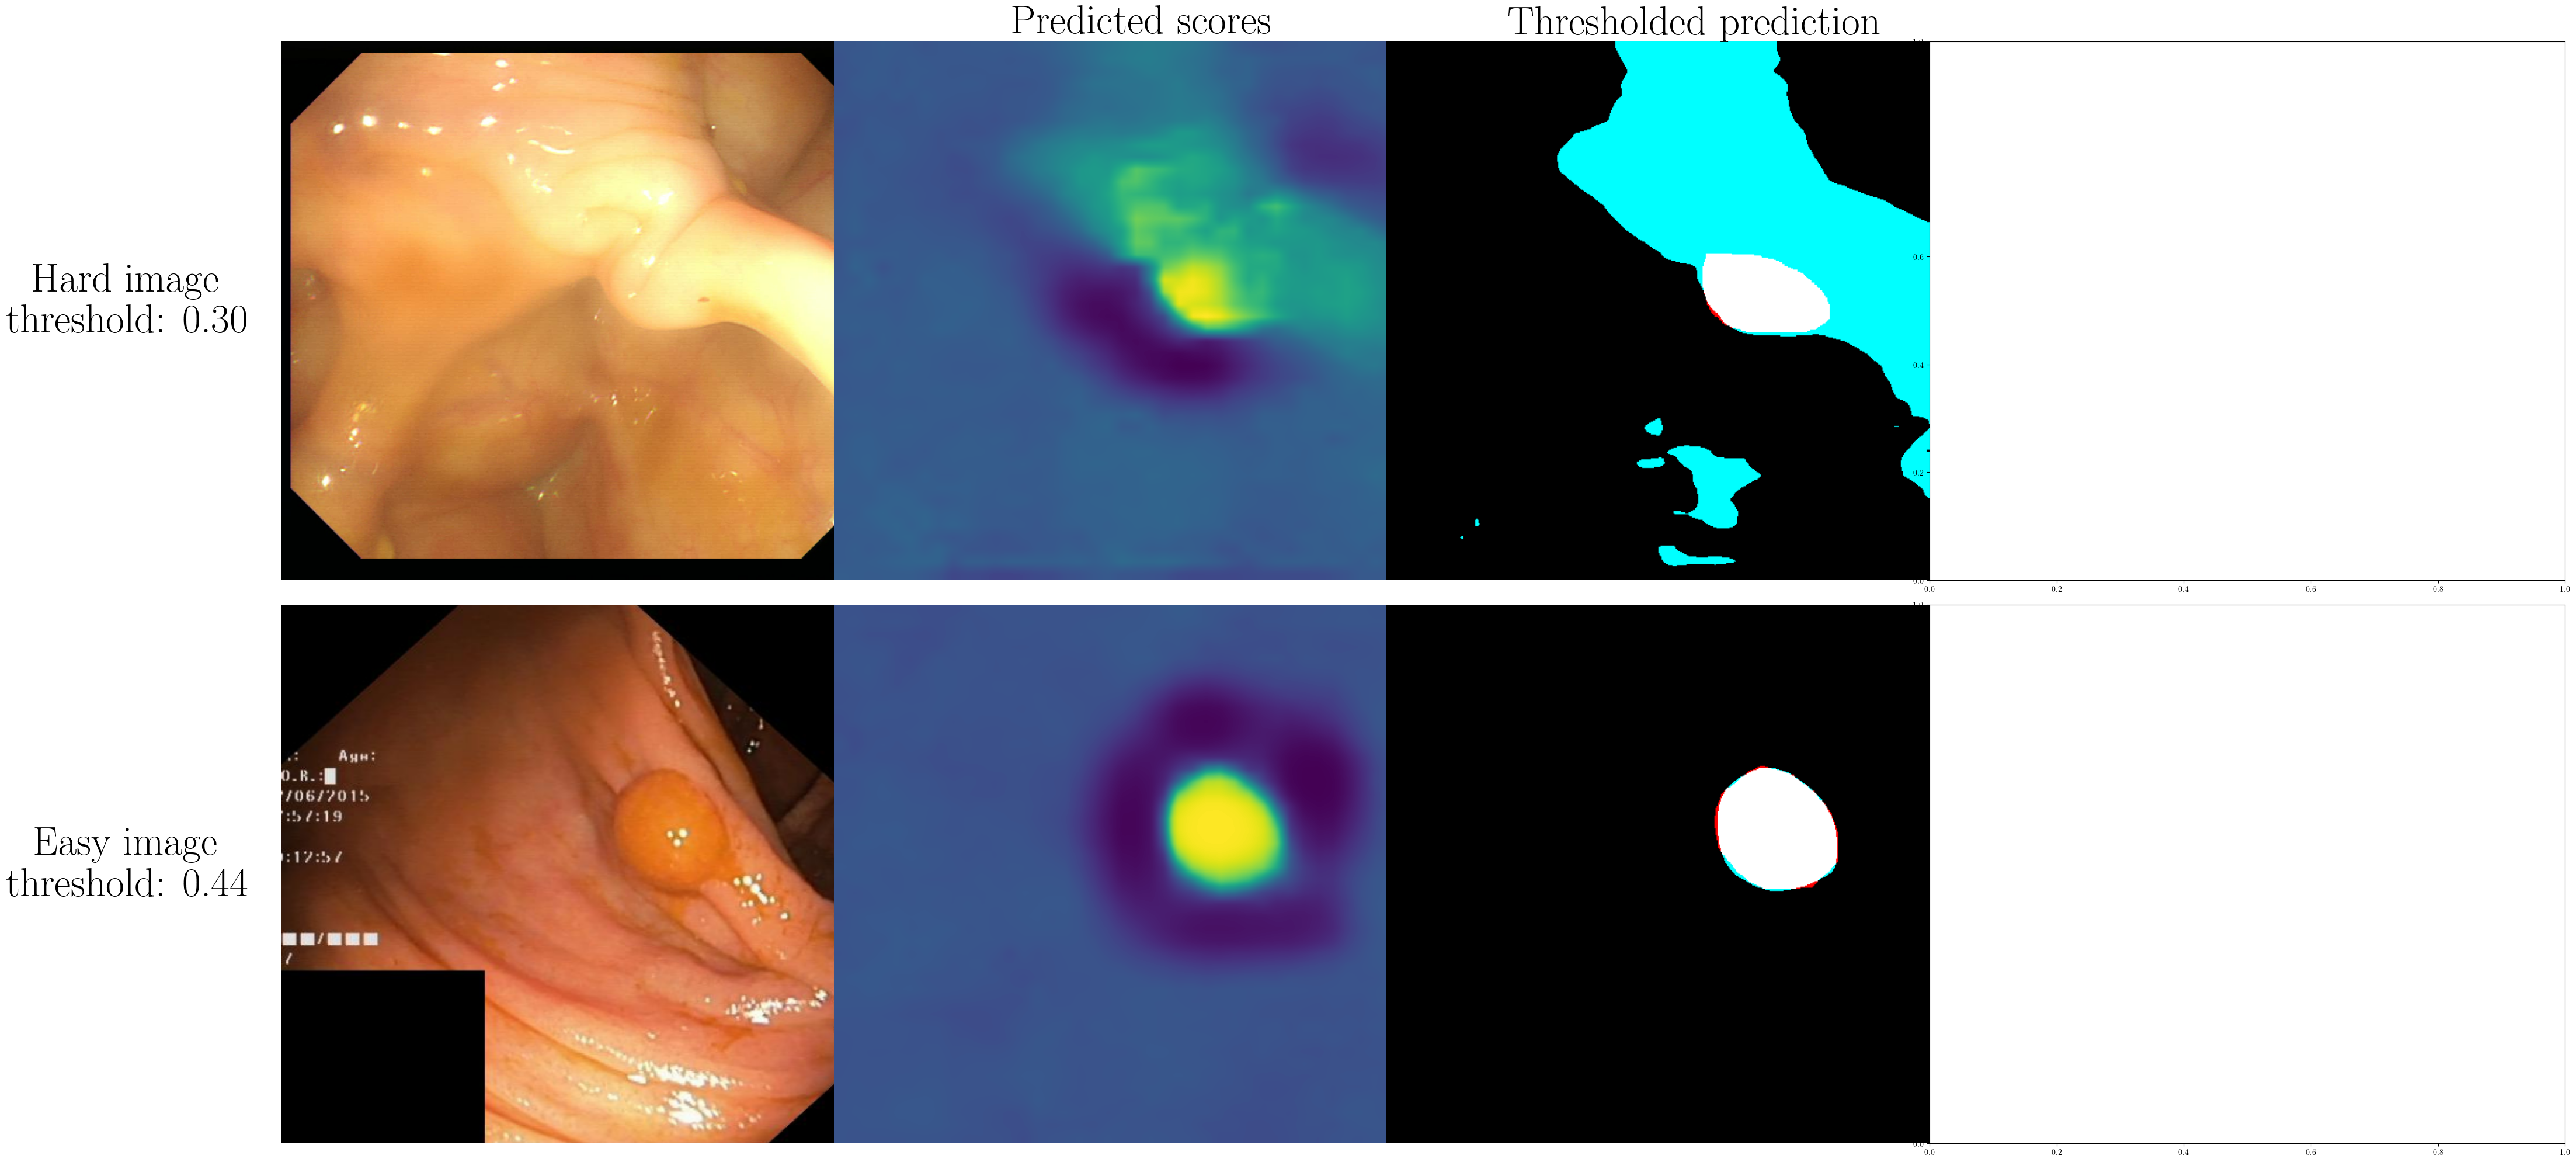

In [25]:
hard_img_id = 271
izy_img_id = np.argsort(ths_res[:, 0, 0])[-2]
s = 10
f, ax = plt.subplots(2, 4, figsize=(4 * s,2 * s))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
hard_img = cv2.imread(os.path.join(DIR_TEST_IMAGES, sorted(os.listdir(DIR_TEST_IMAGES))[hard_img_id]))
hard_img = cv2.cvtColor(hard_img, cv2.COLOR_BGR2RGB)
pred_proba_hard = np.load(os.path.join(DIR_TEST_PRED_PROBAS, sorted(os.listdir(DIR_TEST_PRED_PROBAS))[hard_img_id]))
hard_label = cv2.imread(os.path.join(DIR_TEST_LABELS, sorted(os.listdir(DIR_TEST_LABELS))[hard_img_id]), cv2.IMREAD_GRAYSCALE) // 255
pred_th_hard = pred_proba_hard >= ths_res[hard_img_id]

izy_img = cv2.imread(os.path.join(DIR_TEST_IMAGES, sorted(os.listdir(DIR_TEST_IMAGES))[izy_img_id]))
izy_img = cv2.cvtColor(izy_img, cv2.COLOR_BGR2RGB)
pred_proba_izy = np.load(os.path.join(DIR_TEST_PRED_PROBAS, sorted(os.listdir(DIR_TEST_PRED_PROBAS))[izy_img_id]))
izy_label = cv2.imread(os.path.join(DIR_TEST_LABELS, sorted(os.listdir(DIR_TEST_LABELS))[izy_img_id]), cv2.IMREAD_GRAYSCALE)

#resize izy image to hard image shape
izy_img = cv2.resize(izy_img, (hard_img.shape[1], hard_img.shape[0]))
izy_label = cv2.resize(izy_label, (hard_img.shape[1], hard_img.shape[0])) // 255
pred_proba_izy = cv2.resize(pred_proba_izy, (hard_img.shape[1], hard_img.shape[0]))

pred_th_izy = pred_proba_izy >= ths_res[izy_img_id]

pred_plot_hard = np.zeros((hard_img.shape[0], hard_img.shape[1], 3)).astype(int)
pred_plot_izt = np.zeros((izy_img.shape[0], izy_img.shape[1], 3)).astype(int)

# tp_crc = pred_th_crc * label
# fp_crc = pred_th_crc * (1 - label)
# fn_crc = (1 - pred_th_crc) * label
# pred_plot_crc[tp_crc == 1] = [255, 255, 255]
# pred_plot_crc[fp_crc == 1] = [0, 255, 255]
# pred_plot_crc[fn_crc == 1] = [255, 0, 0]

# tp_res = pred_th_res * label
# fp_res = pred_th_res * (1 - label)
# fn_res = (1 - pred_th_res) * label

tp_hard = pred_th_hard * hard_label
fp_hard = pred_th_hard * (1 - hard_label)
fn_hard = (1 - pred_th_hard) * hard_label
pred_plot_hard[tp_hard == 1] = [255, 255, 255]
pred_plot_hard[fp_hard == 1] = [0, 255, 255]
pred_plot_hard[fn_hard == 1] = [255, 0, 0]

tp_izy = pred_th_izy * izy_label
fp_izy = pred_th_izy * (1 - izy_label)
fn_izy = (1 - pred_th_izy) * izy_label
pred_plot_izt[tp_izy == 1] = [255, 255, 255]
pred_plot_izt[fp_izy == 1] = [0, 255, 255]
pred_plot_izt[fn_izy == 1] = [255, 0, 0]

ax[0, 0].imshow(hard_img)
ax[0, 0].set_title(f"Hard image\n threshold: {ths_res[hard_img_id][0][0]:.2f}", x=-.25, y=.45, fontsize=50)
ax[0, 0].set_axis_off()

ax[0, 1].imshow(pred_proba_hard)
ax[0, 1].set_title("Predicted scores", fontsize=50)
ax[0, 1].set_axis_off()

ax[0, 2].imshow(pred_plot_hard)
ax[0, 2].set_axis_off()
ax[0, 2].set_title("Thresholded prediction", fontsize=50)

ax[1, 0].imshow(izy_img)
ax[1, 0].set_axis_off()
ax[1, 0].set_title(f"Easy image\n threshold: {ths_res[izy_img_id][0][0]:.2f}", x=-.25, y=.45, fontsize=50)

ax[1, 1].imshow(pred_proba_izy)
ax[1, 1].set_axis_off()

ax[1, 2].imshow(pred_plot_izt)
ax[1, 2].set_axis_off()

plt.subplots_adjust(wspace=-0.51, hspace=0)
plt.tight_layout()
plt.savefig("hard_easy_img.pdf", bbox_inches='tight')
plt.show()




# Just little cherry picking with images where CRC achieve a reasonable precisionx

In [26]:
indx_prec_ok = np.where(precision_test_crc >= .5)[0]
diff_precision = precision_test_resnet[indx_prec_ok] - precision_test_crc[indx_prec_ok]
index_diff_prec_not_nan = np.where(~np.isnan(diff_precision))[0]

index_diff_geq = np.where(diff_precision[index_diff_prec_not_nan] >= .3)[0]

In [27]:
diff_precision.max()

0.43886462882096067

In [28]:
# N_IMAGES = 10
# N_ROWS = 3
# s = 8
# IMG_SIZE = 512
# np.random.seed(0)
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# f, ax = plt.subplots(N_ROWS, N_IMAGES, figsize=(N_IMAGES * s, N_ROWS * s))
# img_names = np.array(sorted(os.listdir(DIR_TEST_LABELS)))[indx_prec_ok][index_diff_prec_not_nan][index_diff_geq]
# indices_random = np.random.choice(len(img_names), N_IMAGES)
# sorted_ths_res = ths_res[indx_prec_ok][index_diff_prec_not_nan][index_diff_geq][indices_random]
# for i, img_name in enumerate(img_names[indices_random]):
#     label = cv2.imread(os.path.join(DIR_TEST_LABELS, img_name), cv2.IMREAD_GRAYSCALE) // 255
#     label = cv2.resize(label, (IMG_SIZE, IMG_SIZE))
#     pred_probas = np.load(os.path.join(DIR_TEST_PRED_PROBAS, img_name.replace(".png", ".npy")))
#     pred_probas = cv2.resize(pred_probas, (IMG_SIZE, IMG_SIZE))
#     img = cv2.imread(os.path.join(DIR_TEST_IMAGES, img_name))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

#     pred_th_res = (pred_probas >= sorted_ths_res[i]).astype(int)
#     pred_th_crc = (pred_probas >= th_crc).astype(int)

#     pred_plot_crc = np.zeros((img.shape[0], img.shape[1], 3)).astype(int)
#     pred_plot_res = np.zeros((img.shape[0], img.shape[1], 3)).astype(int)

#     tp_crc = pred_th_crc * label
#     fp_crc = pred_th_crc * (1 - label)
#     fn_crc = (1 - pred_th_crc) * label
#     pred_plot_crc[tp_crc == 1] = [255, 255, 255]
#     pred_plot_crc[fp_crc == 1] = [0, 255, 255]
#     pred_plot_crc[fn_crc == 1] = [255, 0, 0]

#     tp_res = pred_th_res * label
#     fp_res = pred_th_res * (1 - label)
#     fn_res = (1 - pred_th_res) * label
#     pred_plot_res[tp_res == 1] = [255, 255, 255]
#     pred_plot_res[fp_res == 1] = [0, 255, 255]
#     pred_plot_res[fn_res == 1] = [255, 0, 0]


#     ax[0, i].imshow(img)
#     ax[1, i].imshow(pred_plot_res)
#     ax[2, i].imshow(pred_plot_crc)
    
#     ax[0, i].set_axis_off()
#     ax[1, i].set_axis_off()
#     ax[2, i].set_axis_off()

# ax[1, 0].set_title("MACP", x=-.15, y=.45, fontsize=50)
# ax[2, 0].set_title("CRC", x=-.15, y=.45, fontsize=50)
# plt.subplots_adjust(wspace=.01, hspace=0.01)
# plt.tight_layout()
# plt.savefig("polyp.pdf", bbox_inches="tight", dpi=300)